# Importando

In [1]:
import locale
locale.setlocale(locale.LC_ALL, '')

import matplotlib as mpl
mpl.rcParams.update({'font.size': 14, 'text.usetex':False})
mpl.rcParams.update({'mathtext.fontset':'dejavusans'})
mpl.rcParams['axes.formatter.use_locale'] = True

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os
from SAXS_FF import WLM_whole_q
import re
from uncertainties import ufloat as uf
import os

# Criando listas e funções adicionais

In [2]:
ajustes = glob.glob('*res*')
dados_60_15 = glob.glob('./P615m/*')
dados_60_3 = glob.glob('./P63m/*')
dados_55 = glob.glob('./55/*')
dados_75 = glob.glob('./75/*')
dados_100 = glob.glob('./100/*')

ajustes

corr_aj_dado = {
    ajustes[0]:dados_60_15,
    ajustes[1]:dados_60_3,
    ajustes[2]:dados_100,
    ajustes[3]:dados_55,
    ajustes[4]:dados_75
}

def find_conc(string):
    if 'P615' in string:
        return '60'
    elif 'P63m' in string:
        return '60'
    elif '100' in string:
        return 100
    elif '55' in string:
        return '55'
    elif '75' in string:
        return '75'

def find_pos(string):
    pattern = re.compile(r'(\d\d)\.dat')
    pos = pattern.search(string)
    if not pos:
        return 'ave'
    else:
        return pos.group(1)


In [3]:
to_add_colorbar = True

# Plotando 60 mM 1,5m

In [4]:
ajuste = ajustes[0]
df = pd.read_csv(ajuste, sep=';', decimal='.')

for line in df.iterrows():
    nome = line[1][0]
    params = line[1][1::2]
    
    primeiro_q = np.log10( exp.iloc[0, 0] / 10 )
    ultimo_q = np.log10( exp.iloc[-1, 0] / 10 )
    qs = np.logspace(primeiro_q, ultimo_q)
    Is = WLM_whole_q(qs, *params)
    
    fig, ax = plt.subplots(1, 1, figsize=(9,6))
    
    exp_index = 0
    for i, dado in enumerate(corr_aj_dado[ajuste]):
        if nome in dado:
            exp_index = i
    
    pos = find_pos(nome).replace('ave', 'Média')
    exp = pd.read_csv(dados_60_15[exp_index], sep=' ', header=2, names=['q', 'I', 'err'])
    
    ax.errorbar(exp['q'] / 10, exp['I'], yerr=exp['err'], c='C0', label='dado')
    ax.plot(qs, Is, 'r--', label='Modelo')
    ax.set(xscale='log', yscale='log', ylabel='I/u.a.', xlabel=r'q/nm$^{-1}$')
    ax.set_ylim((2e-4, 0.01257))
    ax.legend(title=f'60:100 NaSal:TTAB -- {pos}')
    
    #ax.set_title(f'Dado:{})
    


NameError: name 'exp' is not defined

## Criando função

In [5]:
def plot_saxs(resultados, plot_dado=True, plot_ajuste=True, plot_junto=True, ylim=None, titulo='', ultimo_ponto=-1,
             conj_dados=None, plot_ave=False):

    if plot_junto:
        fig, ax = plt.subplots(1, 1, figsize=(9,6))
        cores = plt.cm.plasma(np.arange(0, len(resultados)) / len(resultados))

    axs = []
    figs = []
    
    for num, line in enumerate(resultados.iterrows()):
        nome = line[1][0]
        
        if 'ave' in nome and not plot_ave:
            continue
        
        params = line[1][1::2]
        
        if not plot_junto:
            fig, ax = plt.subplots(1, 1, figsize=(9,6))
            axs.append(ax)
            figs.append(fig)

        exp_index = 0
        #for i, dado in enumerate(corr_aj_dado[ajuste]):  # todo: tirar esse ajuste daqui
        for i, dado in enumerate(conj_dados):
            if nome in dado:
                exp_index = i

        pos = find_pos(nome).replace('ave', 'Média')
        exp = pd.read_csv(conj_dados[exp_index], sep=' ', header=2, names=['q', 'I', 'err'])
        
        exp = exp.iloc[:ultimo_ponto, :]
        
        primeiro_q = np.log10( exp.iloc[0, 0] / 10 )
        ultimo_q = np.log10( exp.iloc[-1, 0] / 10 )
        qs = np.logspace(primeiro_q, ultimo_q)
        Is = WLM_whole_q(qs, *params)
        
        if plot_dado and not plot_junto:
            ax.errorbar(exp['q'] / 10, exp['I'], yerr=exp['err'], c='C0', label='dado')
        
        if plot_dado and plot_junto:
            ax.errorbar(exp['q'] / 10, exp['I'], yerr=exp['err'], c=cores[num], label=pos, capsize=3, alpha=0.5)
        
        if plot_ajuste and not plot_junto:
            ax.plot(qs, Is, 'r--', label='Modelo')
        
        if plot_ajuste and plot_junto:
            ax.plot(qs, Is, label=pos, ls='-', c=cores[num], alpha=0.5)
            
        ax.set(xscale='log', yscale='log', ylabel='I/u.a.', xlabel=r'q/nm$^{-1}$')
        ax.set_ylim(ylim)
        ax.legend(title=f'{titulo} -- {pos}')
        ax.legend_.set_visible(False)
        
        #ax.set_title()
        

    if plot_junto:
        return fig, ax
    else:
        return figs, axs
    
def add_colorbar(f, a):
    labels = a.get_legend_handles_labels()[0]

    n_lines = len(labels)
    c = np.arange(1., n_lines + 1)

    cmap = plt.get_cmap("plasma", len(c))
    norm = mpl.colors.BoundaryNorm(np.arange(len(c) + 1) + 0.5 , len(c))
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])

    nums = list(range(0, n_lines + 1, 1))

    for i, num in enumerate(nums):
        if num == 0:
            nums[i] = '1'
        elif not num % 5:
            nums[i - 1] = str(num)
            nums[i] = ''
        else:
            nums[i] = ''

    cbar = f.colorbar(sm, ticks=c)

    cbar.set_ticklabels(nums)
    cbar.set_label('Frame')
    
    return cbar



## Dados

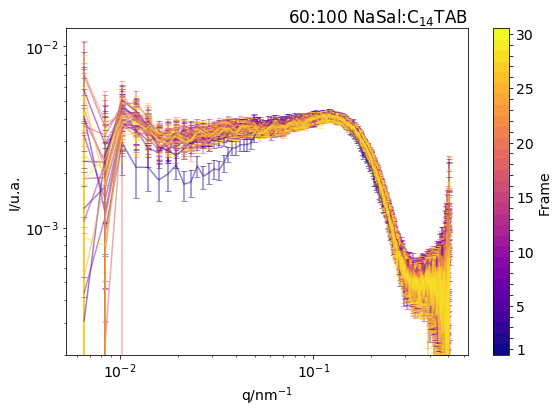

In [7]:
mpl.rcParams.update({'font.size': 14, 'text.usetex':False})

ajuste = ajustes[0]
df = pd.read_csv(ajuste, sep=';', decimal='.')

f, a = plot_saxs(df, ylim=(2e-4, 0.01257), titulo=r'60:100 NaSal:C$_{14}$TAB', plot_junto=True, plot_dado=True, plot_ajuste=False,
                 conj_dados=dados_60_15, plot_ave=False)
a.set_title('60:100 NaSal:C$_{14}$TAB', loc='right')

if to_add_colorbar:
    add_colorbar(f, a)
    
f.savefig('../../../saxs/TR_saxs_60_100_15_dados.pdf')

## Ajustes

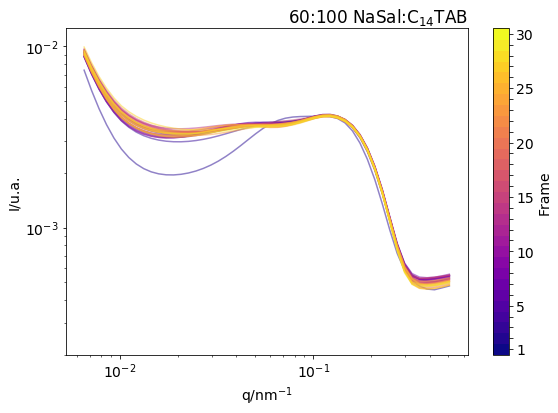

In [8]:
ajuste = ajustes[0]
df = pd.read_csv(ajuste, sep=';', decimal='.')

f, a = plot_saxs(df, ylim=(2e-4, 0.01257), titulo='60:100 NaSal:TTAB', plot_junto=True, plot_dado=False, plot_ajuste=True,
                 conj_dados=dados_60_15, plot_ave=False)
a.set_title('60:100 NaSal:C$_{14}$TAB', loc='right')

if to_add_colorbar:
    add_colorbar(f, a)

f.savefig('../../../saxs/TR_saxs_60_100_15_ajustes.pdf')

## Primeiro e média

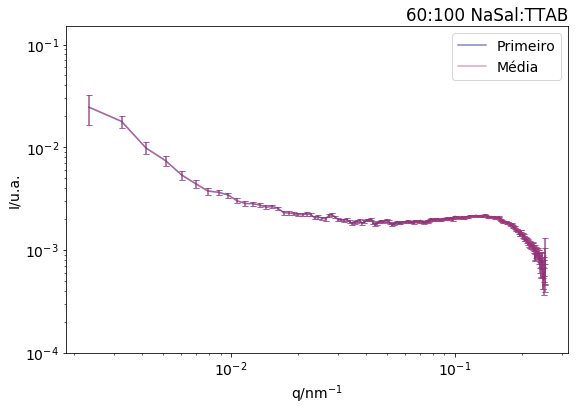

In [14]:
ajuste = ajustes[0]
df = pd.read_csv(ajuste, sep=';', decimal='.')
df = pd.DataFrame([df.iloc[1, :], df.iloc[0, :]])

f, a = plot_saxs(df, titulo='60:100 NaSal:TTAB', plot_junto=True, plot_dado=True, plot_ajuste=False,
                conj_dados=dados_55, plot_ave=True)

a.set_title('60:100 NaSal:TTAB', loc='right')
a.set_ylim(bottom=1E-4, top=1.5E-1)
a.legend(handles=a.get_lines()[0::3], labels=['Primeiro', 'Média'])
#f.savefig('../../../saxs/TR_saxs_55_55_ajuste.pdf')

# Plotando 60 mM 3m

## Só ajustes

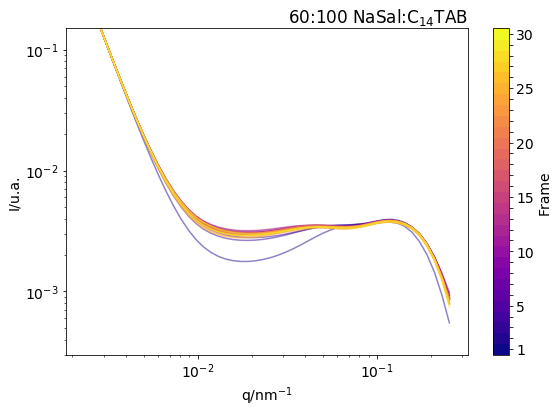

In [9]:
ajuste = ajustes[1]
df = pd.read_csv(ajuste, sep=';', decimal='.')
f, a = plot_saxs(df, titulo='60:100 NaSal:TTAB', plot_junto=True, plot_dado=False,
                ultimo_ponto=-1, conj_dados=dados_60_3, plot_ave=False)
a.set_title('60:100 NaSal:C$_{14}$TAB', loc='right')
a.set_ylim((3E-4, 1.5E-1))

if to_add_colorbar:
    add_colorbar(f, a)

f.savefig('../../../saxs/TR_saxs_60_100_3_ajustes.pdf')

## Só dados

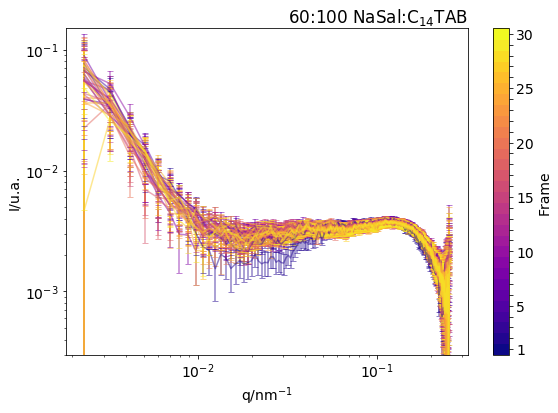

In [10]:
ajuste = ajustes[1]
df = pd.read_csv(ajuste, sep=';', decimal='.')
f, a = plot_saxs(df, titulo='60:100 NaSal:TTAB', plot_junto=True, plot_dado=True, plot_ajuste=False,
                 conj_dados=dados_60_3, plot_ave=False
                )
a.set_title('60:100 NaSal:C$_{14}$TAB', loc='right')
a.set_ylim((3E-4, 1.5E-1))

if to_add_colorbar:
    add_colorbar(f, a)

f.savefig('../../../saxs/TR_saxs_60_100_3_dados.pdf')

## Primeiro e média

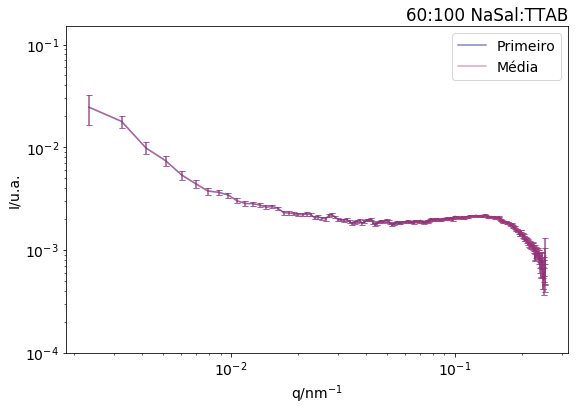

In [17]:
ajuste = ajustes[1]
df = pd.read_csv(ajuste, sep=';', decimal='.')
df = pd.DataFrame([df.iloc[1, :], df.iloc[0, :]])

f, a = plot_saxs(df, titulo='60:100 NaSal:TTAB', plot_junto=True, plot_dado=True, plot_ajuste=False,
                conj_dados=dados_55, plot_ave=True)

a.set_title('60:100 NaSal:TTAB', loc='right')
a.set_ylim(bottom=1E-4, top=1.5E-1)
a.legend(handles=a.get_lines()[0::3], labels=['Primeiro', 'Média'])
#f.savefig('../../../saxs/TR_saxs_55_55_ajuste.pdf')

## Dado e ajuste

ajuste = ajustes[1]
df = pd.read_csv(ajuste, sep=';', decimal='.')

f, a = plot_saxs(df, titulo='60:100 NaSal:TTAB', plot_junto=False, plot_dado=True, plot_ajuste=True,
                conj_dados=dados_60_3, plot_ave=False)

# Plotando 100:100

## Dado

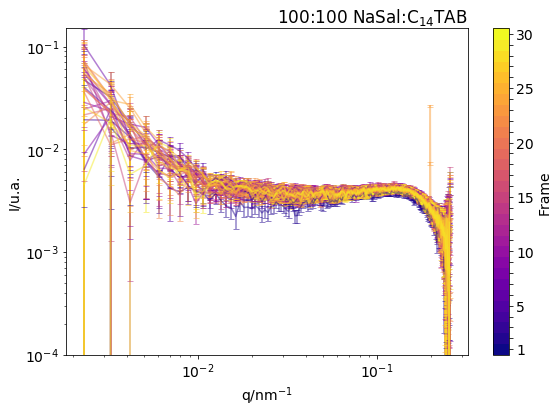

In [11]:
ajuste = ajustes[2]
df = pd.read_csv(ajuste, sep=';', decimal='.')

f, a = plot_saxs(df, titulo='100:100 NaSal:TTAB', plot_junto=True, plot_dado=True, plot_ajuste=False,
                conj_dados=dados_100, plot_ave=False)

a.set_title('100:100 NaSal:C$_{14}$TAB', loc='right')
a.set_ylim(bottom=1E-4, top=1.5E-1)

if to_add_colorbar:
    add_colorbar(f, a)
    
f.savefig('../../../saxs/TR_saxs_100_100_dados.pdf')

## Ajuste

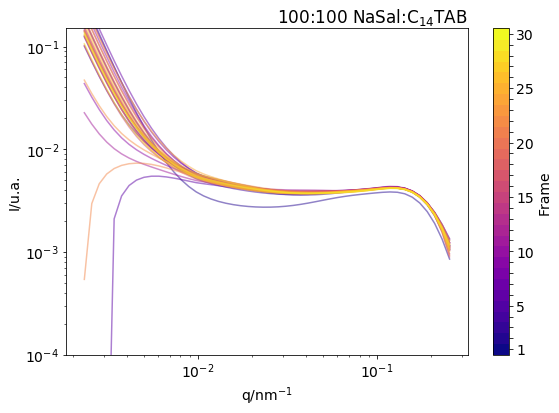

In [12]:
ajuste = ajustes[2]
df = pd.read_csv(ajuste, sep=';', decimal='.')

f, a = plot_saxs(df, titulo='100:100 NaSal:TTAB', plot_junto=True, plot_dado=False, plot_ajuste=True,
                conj_dados=dados_100, plot_ave=False)

a.set_title('100:100 NaSal:C$_{14}$TAB', loc='right')
a.set_ylim(bottom=1E-4, top=1.5E-1)

if to_add_colorbar:
    add_colorbar(f, a)
    
f.savefig('../../../saxs/TR_saxs_100_100_ajustes.pdf')

## Primeiro e média

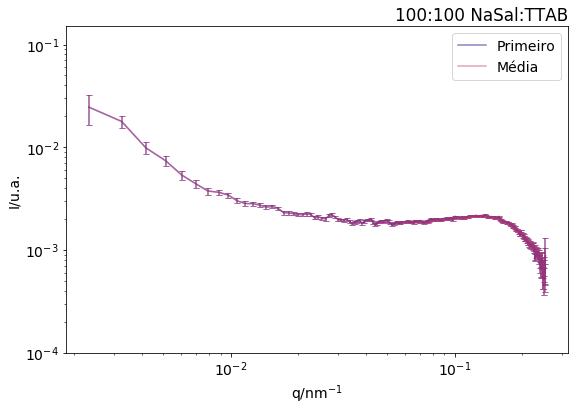

In [20]:
ajuste = ajustes[2]
df = pd.read_csv(ajuste, sep=';', decimal='.')
df = pd.DataFrame([df.iloc[1, :], df.iloc[0, :]])

f, a = plot_saxs(df, titulo='100:100 NaSal:TTAB', plot_junto=True, plot_dado=True, plot_ajuste=False,
                conj_dados=dados_55, plot_ave=True)

a.set_title('100:100 NaSal:TTAB', loc='right')
a.set_ylim(bottom=1E-4, top=1.5E-1)
a.legend(handles=a.get_lines()[0::3], labels=['Primeiro', 'Média'])
#f.savefig('../../../saxs/TR_saxs_55_55_ajuste.pdf')

## Juntos

ajuste = ajustes[2]
df = pd.read_csv(ajuste, sep=';', decimal='.')

f, a = plot_saxs(df, titulo='100:100 NaSal:TTAB', plot_junto=False, plot_dado=True, plot_ajuste=True,
                conj_dados=dados_100)

# Plotando 75:75

## Dado

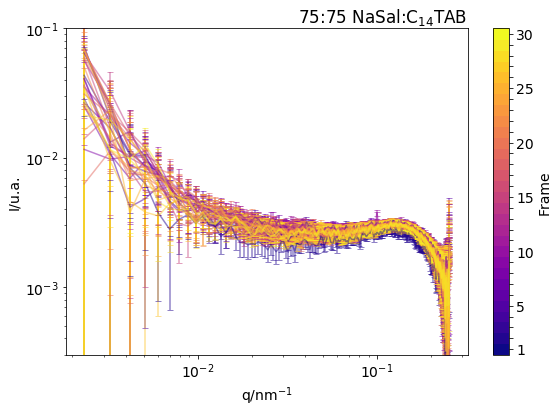

In [13]:
ajuste = ajustes[-1]
df = pd.read_csv(ajuste, sep=';', decimal='.')

f, a = plot_saxs(df, titulo='75:75 NaSal:TTAB', plot_junto=True, plot_dado=True, plot_ajuste=False,
                conj_dados=dados_75, plot_ave=False)

a.set_title('75:75 NaSal:C$_{14}$TAB', loc='right')
a.set_ylim(bottom=3E-4, top=1E-1)

if to_add_colorbar:
    add_colorbar(f, a)
    
    
f.savefig('../../../saxs/TR_saxs_75_75_dados.pdf')

## Ajuste

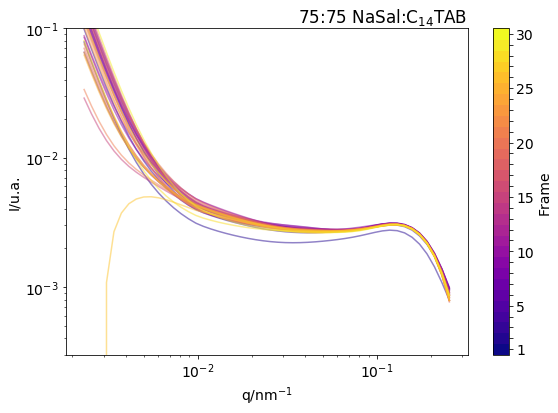

In [14]:
ajuste = ajustes[-1]
df = pd.read_csv(ajuste, sep=';', decimal='.')

f, a = plot_saxs(df, titulo='75:75 NaSal:TTAB', plot_junto=True, plot_dado=False, plot_ajuste=True,
                conj_dados=dados_75, plot_ave=False)

a.set_title('75:75 NaSal:C$_{14}$TAB', loc='right')
a.set_ylim(bottom=3E-4, top=1E-1)

if to_add_colorbar:
    add_colorbar(f, a)
    
f.savefig('../../../saxs/TR_saxs_75_75_ajuste.pdf')

## Primeiro e média

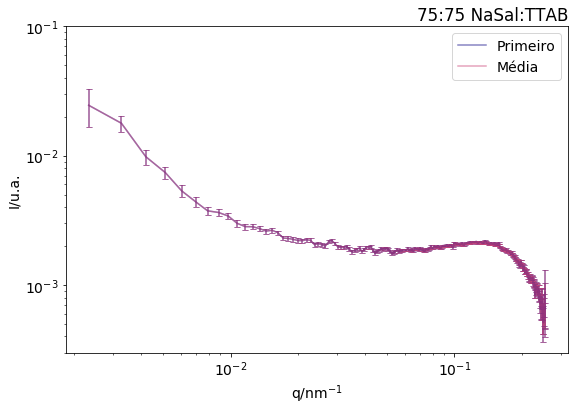

In [23]:
ajuste = ajustes[-1]
df = pd.read_csv(ajuste, sep=';', decimal='.')
df = pd.DataFrame([df.iloc[1, :], df.iloc[0, :]])

f, a = plot_saxs(df, titulo='75:75 NaSal:TTAB', plot_junto=True, plot_dado=True, plot_ajuste=False,
                conj_dados=dados_55, plot_ave=True)

a.set_title('75:75 NaSal:TTAB', loc='right')
a.set_ylim(bottom=3E-4, top=1E-1)
a.legend(handles=a.get_lines()[0::3], labels=['Primeiro', 'Média'])
#f.savefig('../../../saxs/TR_saxs_55_55_ajuste.pdf')

## Juntos

ajuste = ajustes[-1]
df = pd.read_csv(ajuste, sep=';', decimal='.')

f, a = plot_saxs(df, titulo='75:75 NaSal:TTAB', plot_junto=False, plot_dado=True, plot_ajuste=True,
                conj_dados=dados_75)

# Plotando 55:55

## Dado

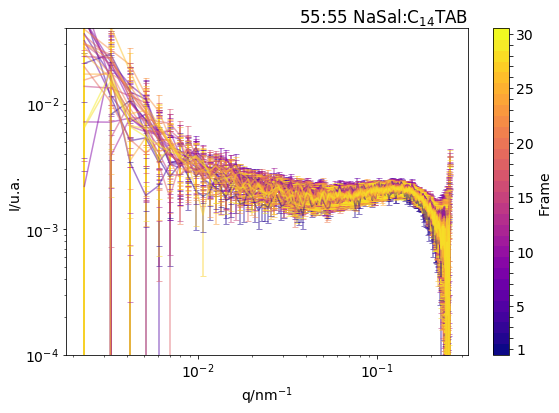

In [15]:
ajuste = ajustes[-2]
df = pd.read_csv(ajuste, sep=';', decimal='.')

f, a = plot_saxs(df, titulo='55:55 NaSal:TTAB', plot_junto=True, plot_dado=True, plot_ajuste=False,
                conj_dados=dados_55, plot_ave=False)

a.set_title('55:55 NaSal:C$_{14}$TAB', loc='right')
a.set_ylim(bottom=1E-4, top=4E-2)

if to_add_colorbar:
    add_colorbar(f, a)
    
    
f.savefig('../../../saxs/TR_saxs_55_55_dados.pdf')

## Ajuste

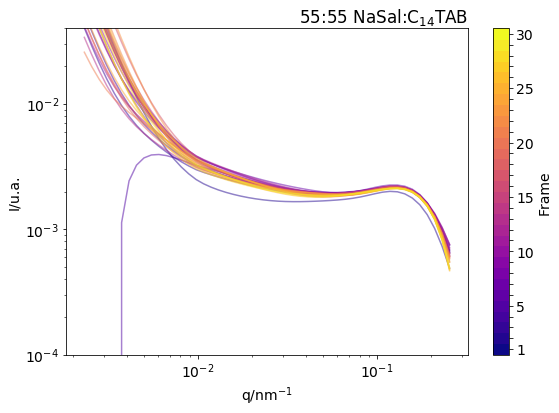

In [16]:
ajuste = ajustes[-2]
df = pd.read_csv(ajuste, sep=';', decimal='.')

f, a = plot_saxs(df, titulo='55:55 NaSal:TTAB', plot_junto=True, plot_dado=False, plot_ajuste=True,
                conj_dados=dados_55, plot_ave=False)

a.set_title('55:55 NaSal:C$_{14}$TAB', loc='right')
a.set_ylim(bottom=1E-4, top=4E-2)

if to_add_colorbar:
    add_colorbar(f, a)
    
    
f.savefig('../../../saxs/TR_saxs_55_55_ajuste.pdf')

## Primeira e média

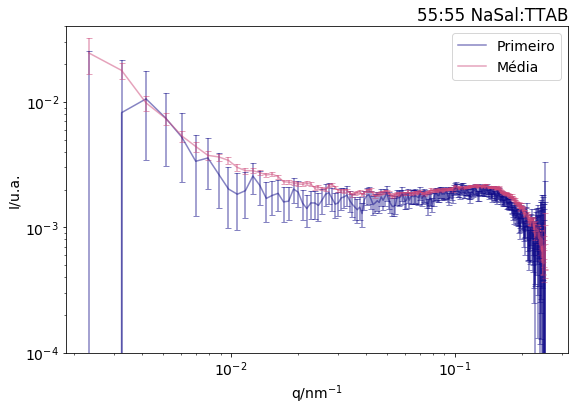

In [26]:
ajuste = ajustes[-2]
df = pd.read_csv(ajuste, sep=';', decimal='.')
df = pd.DataFrame([df.iloc[1, :], df.iloc[0, :]])

f, a = plot_saxs(df, titulo='55:55 NaSal:TTAB', plot_junto=True, plot_dado=True, plot_ajuste=False,
                conj_dados=dados_55, plot_ave=True)

a.set_title('55:55 NaSal:TTAB', loc='right')
a.set_ylim(bottom=1E-4, top=4E-2)
a.legend(handles=a.get_lines()[0::3], labels=['Primeiro', 'Média'])
#f.savefig('../../../saxs/TR_saxs_55_55_ajuste.pdf')

## Juntos

ajuste = ajustes[-2]
df = pd.read_csv(ajuste, sep=';', decimal='.')

f, a = plot_saxs(df, titulo='55:55 NaSal:TTAB', plot_junto=False, plot_dado=True, plot_ajuste=True,
                conj_dados=dados_55)

# Plotando gráficos com as propriedades

## Teste

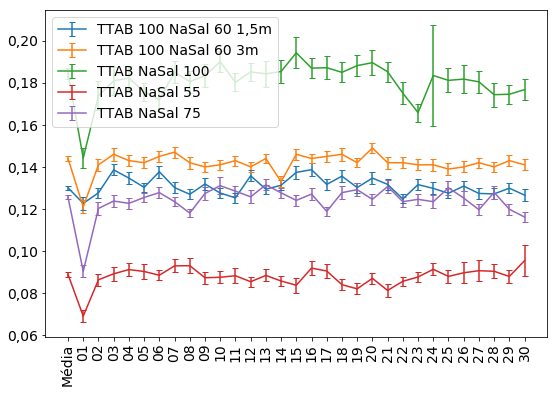

In [343]:
fig, ax = plt.subplots(1, 1, figsize=(9,6))

for ajuste in ajustes:
    df = pd.read_csv(ajuste, sep=';', decimal='.')
    df['numero'] = df['name'].apply(find_pos).apply(lambda x: x.replace('ave', 'Média'))
    #print(df.columns)

    ax.errorbar(df['numero'], df['scale'], yerr=df['err'], capsize=3, label=ajuste[8:-4])

    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
        
ax.legend()

## Todos

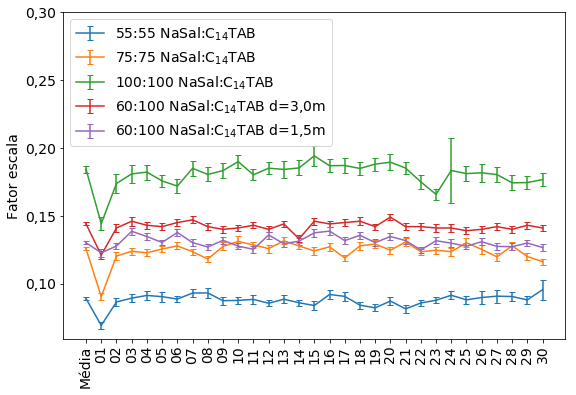

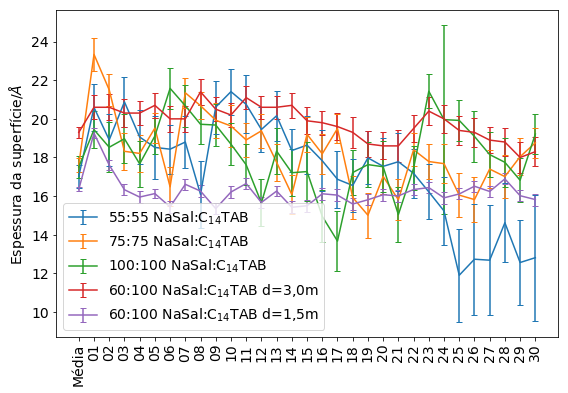

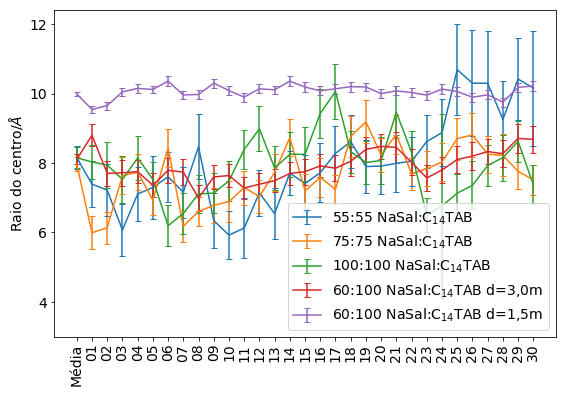

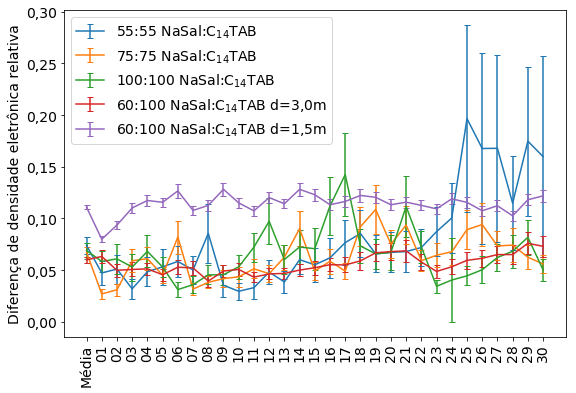

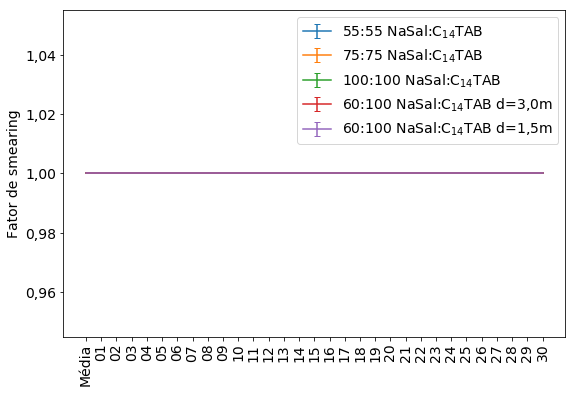

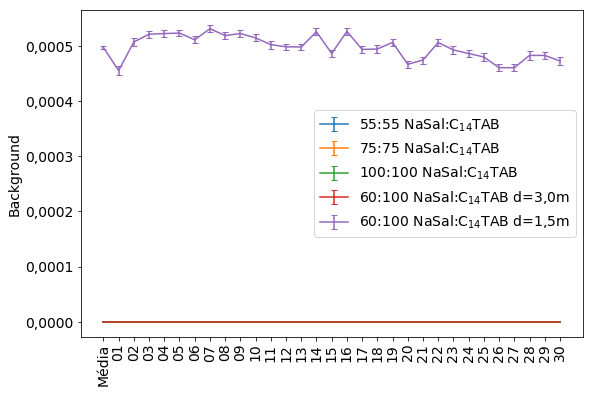

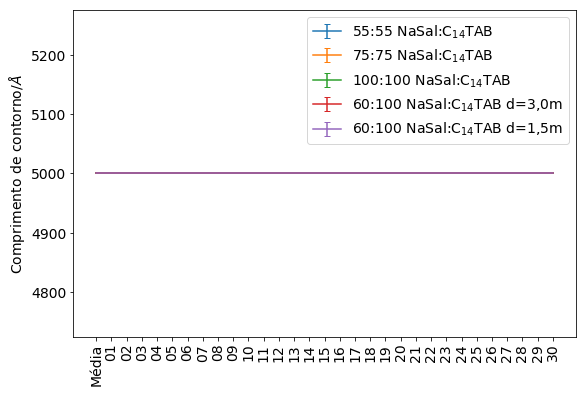

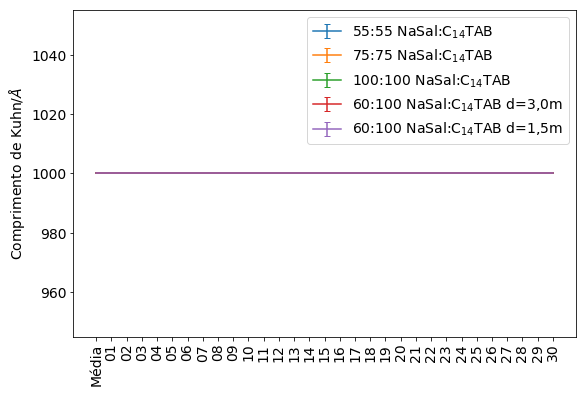

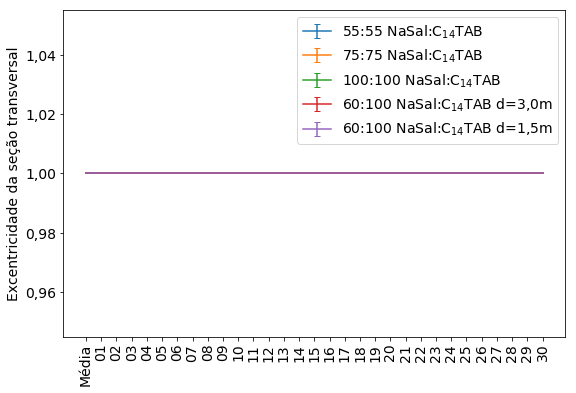

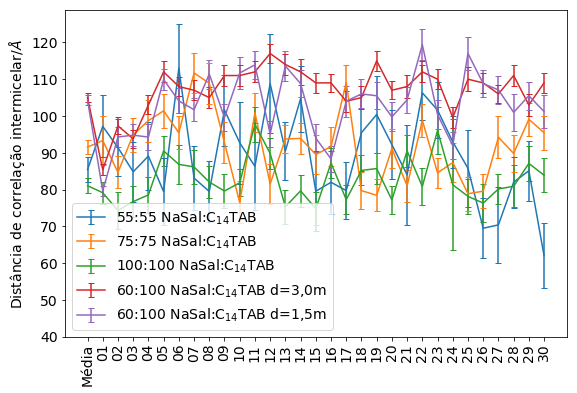

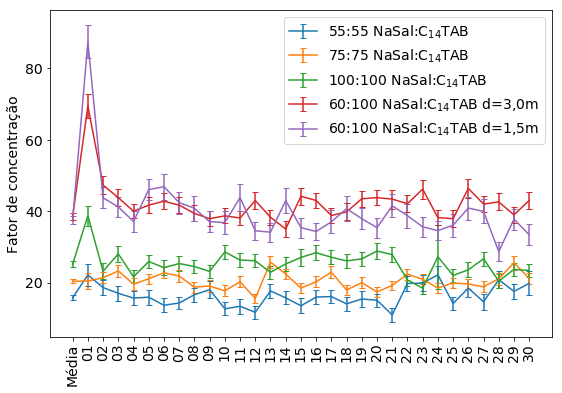

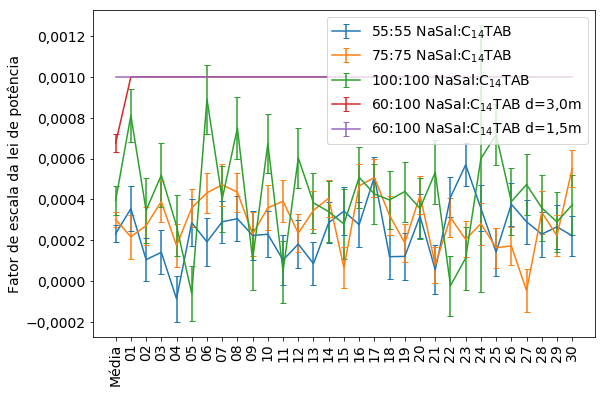

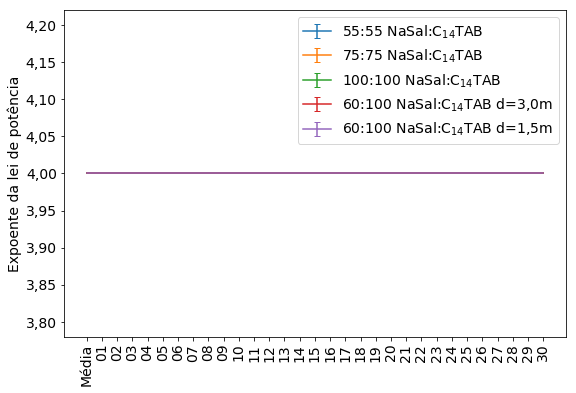

In [17]:
ajuste = ajustes[0]
master_df = pd.read_csv(ajuste, sep=';', decimal='.')
master_df['numero'] = master_df['name'].apply(find_pos).apply(lambda x: x.replace('ave', 'Média'))
master_df.sort_values('numero', inplace=True)

figs = {}
axs = {}

dict_nomes_params = {
    'scale':'Fator escala',
    'd_head':'Espessura da superfície/$\AA$',
    'rad_core':'Raio do centro/$\AA$',
    'rho_rel':'Diferença de densidade eletrônica relativa',
    'sigma':'Fator de smearing',
    'bck':'Background',
    'l_cont':'Comprimento de contorno/$\AA$',
    'b_kuhn':'Comprimento de Kuhn/$\AA$',
    'eps_xs':'Excentricidade da seção transversal',
    'd_cq':'Distância de correlação intermicelar/$\AA$',
    'nu_rpa':'Fator de concentração',
    'sc_pow':'Fator de escala da lei de potência',
    'exp':'Expoente da lei de potência'
}

dict_nomes_exps = {
    'TTAB 100 NaSal 60 1,5m':'60:100 NaSal:C$_{14}$TAB d=1,5m',
    'TTAB 100 NaSal 60 3m':'60:100 NaSal:C$_{14}$TAB d=3,0m',
    'TTAB NaSal 100':'100:100 NaSal:C$_{14}$TAB',
    'TTAB NaSal 55':'55:55 NaSal:C$_{14}$TAB',
    'TTAB NaSal 75':'75:75 NaSal:C$_{14}$TAB'
}

ajustes_params = [
     'results TTAB NaSal 55.csv',
     'results TTAB NaSal 75.csv',
     'results TTAB NaSal 100.csv',
     'results TTAB 100 NaSal 60 3m.csv',
     'results TTAB 100 NaSal 60 1,5m.csv'
]

for param, err in zip(master_df.columns[1:-1:2], master_df.columns[2:-1:2]):
    fig, ax = plt.subplots(1, 1, figsize=(9,6))
    for ajuste in ajustes_params:
        df = pd.read_csv(ajuste, sep=';', decimal='.', na_values='*FIXED')
        df['numero'] = df['name'].apply(find_pos).apply(lambda x: x.replace('ave', 'Média'))
        
        ax.errorbar(df['numero'], df[param], yerr=df[err], capsize=3, label=dict_nomes_exps[ajuste[8:-4]])

        for tick in ax.get_xticklabels():
            tick.set_rotation(90)

    ax.legend(fontsize='medium')
    #ax.set_title(dict_nomes_params[param], loc='right')
    
    figs[param] = fig
    axs[param] = ax
    
for param, ax in axs.items():
    ax.set_ylabel(dict_nomes_params[param])
    #ax.set_xlabel('Número do frame')
    
axs['scale'].set_ylim(top=0.3)
axs['rad_core'].set_ylim(bottom=3)
axs['d_cq'].set_ylim(bottom=40)

param_para_salvar = [
    'scale',
    'd_head',
    'rad_core',
    'rho_rel',
    'd_cq',
    'nu_rpa'
]

for name, fig in figs.items():
    if name in param_para_salvar:
        fig.savefig(rf'../../../saxs/param_{name}.pdf')

# Calculando $R^2$

c:\users\karl\anaconda3\lib\site-packages\matplotlib\pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


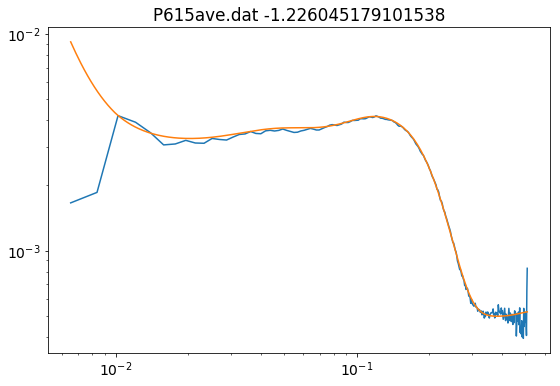

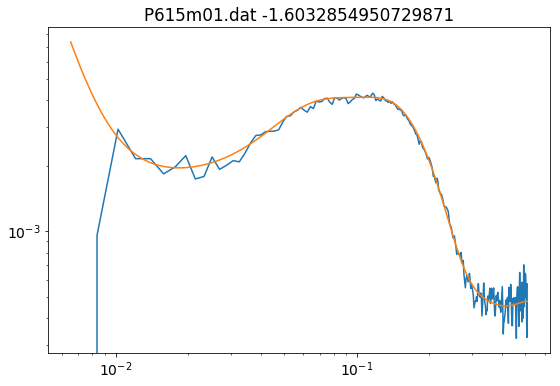

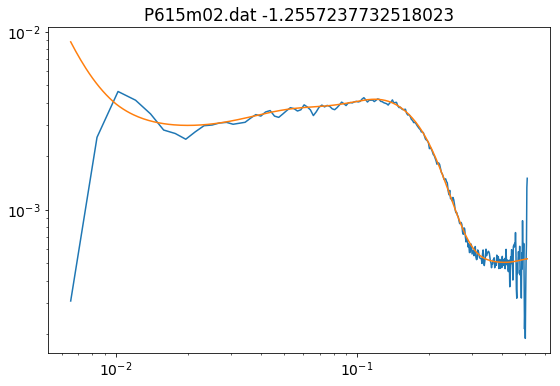

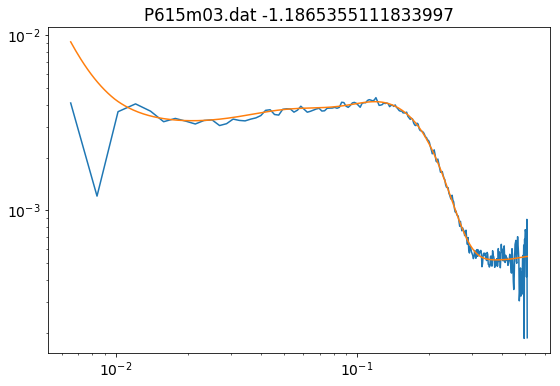

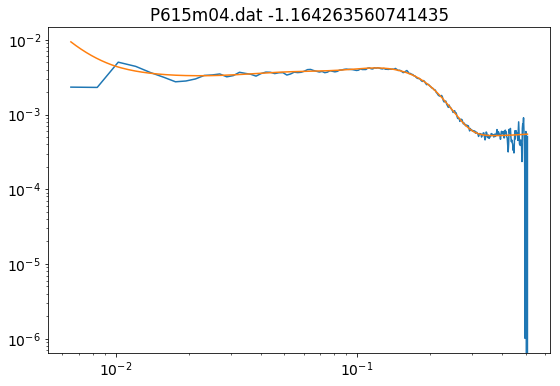

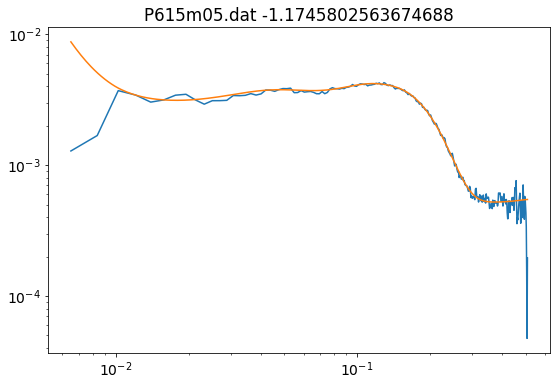

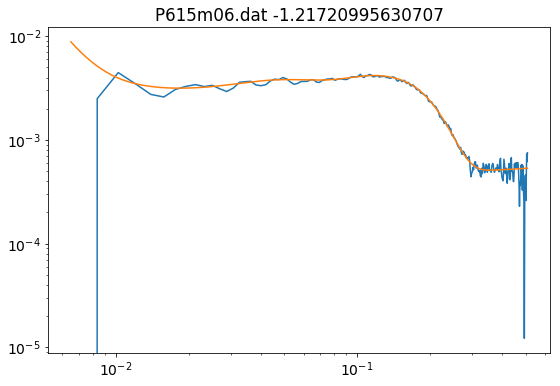

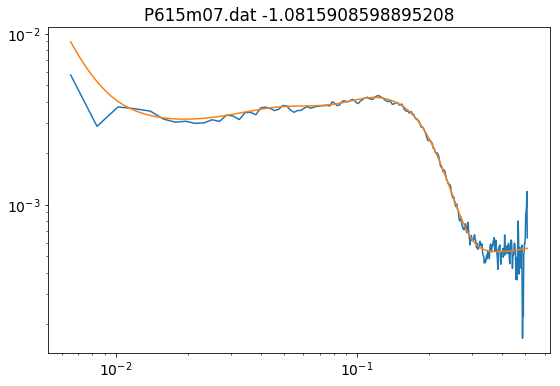

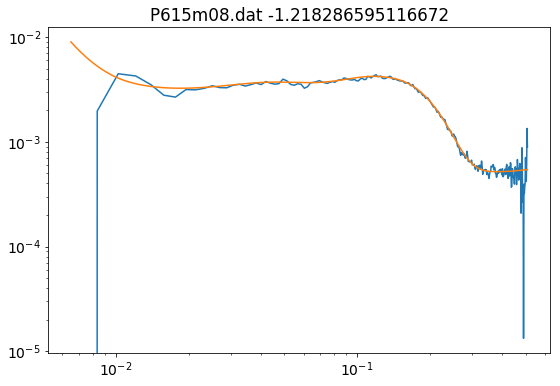

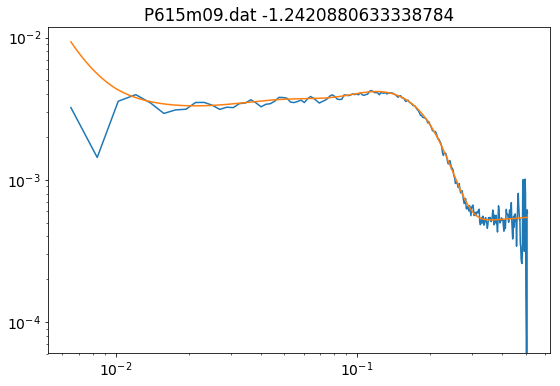

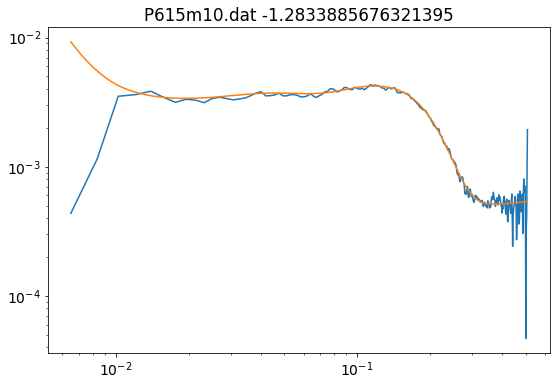

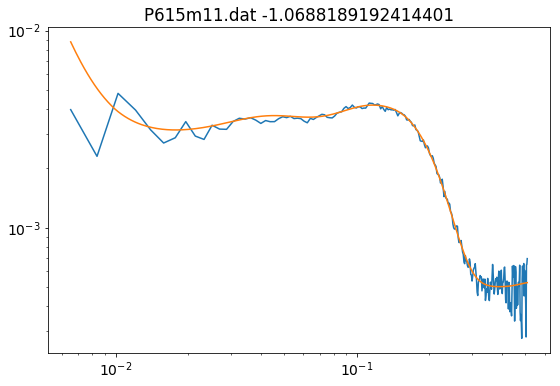

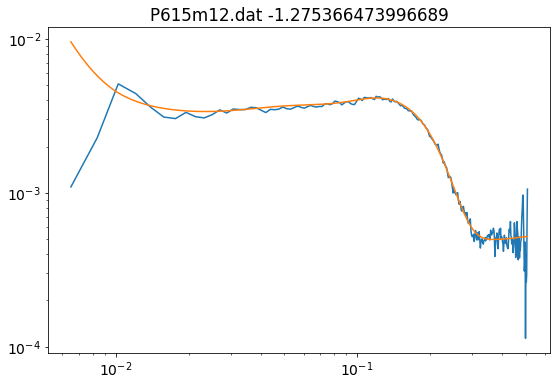

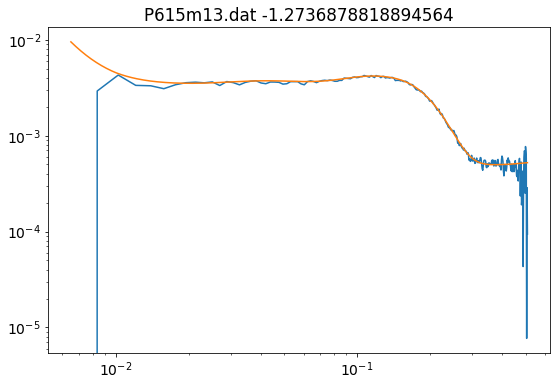

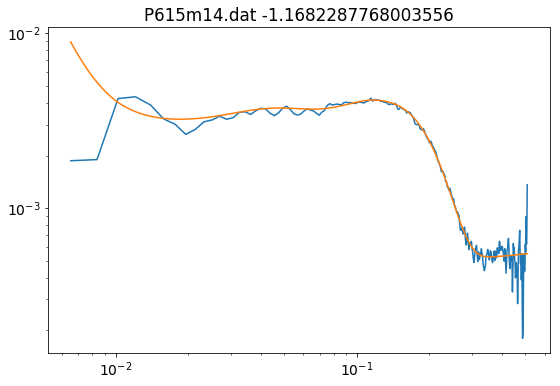

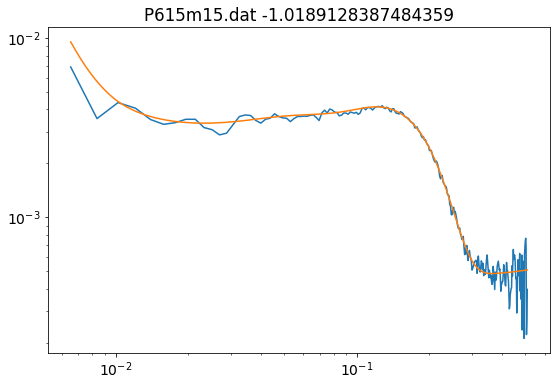

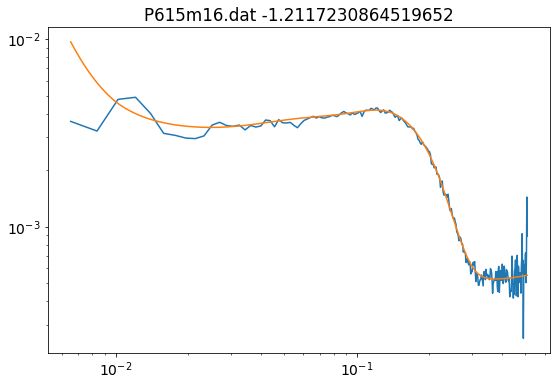

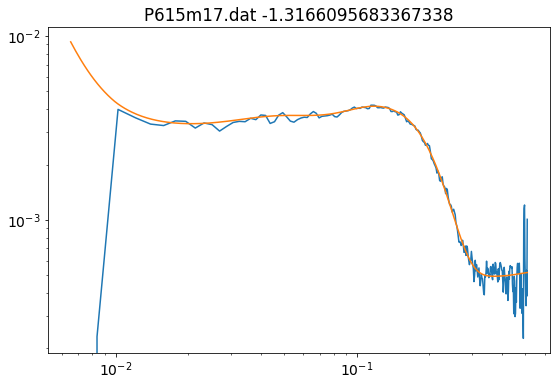

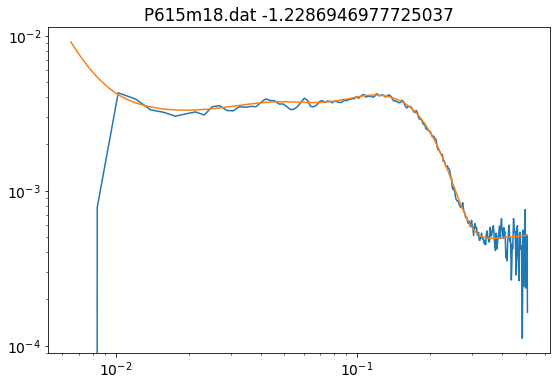

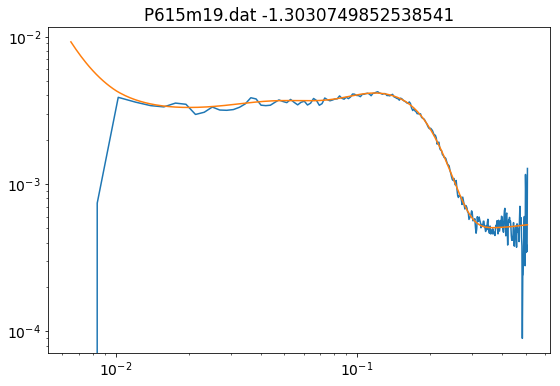

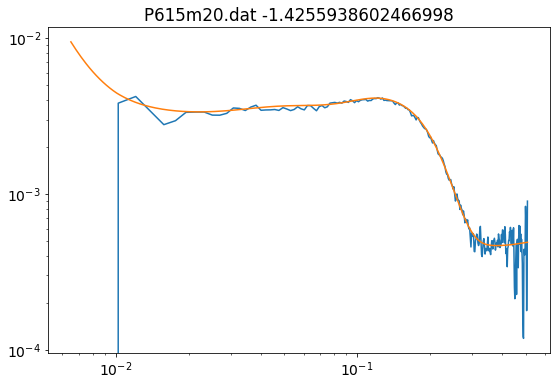

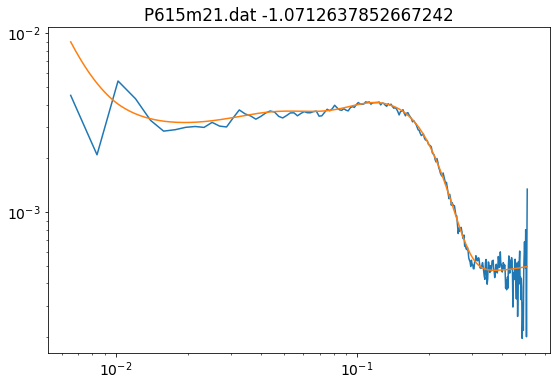

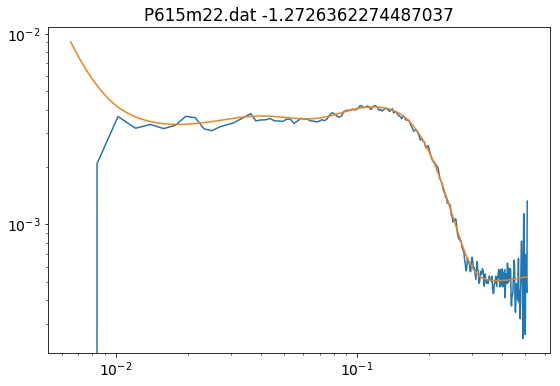

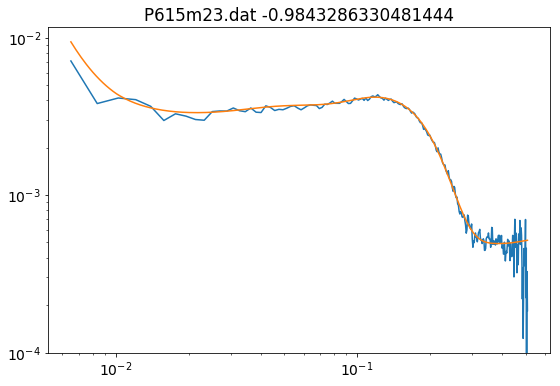

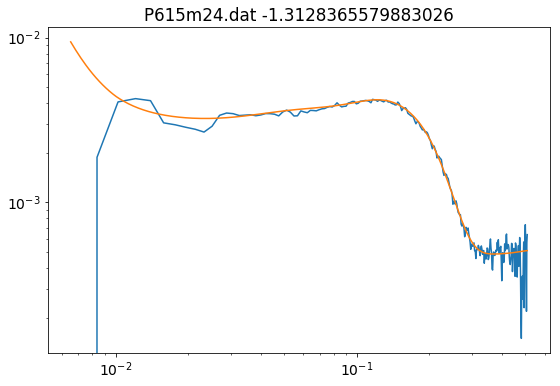

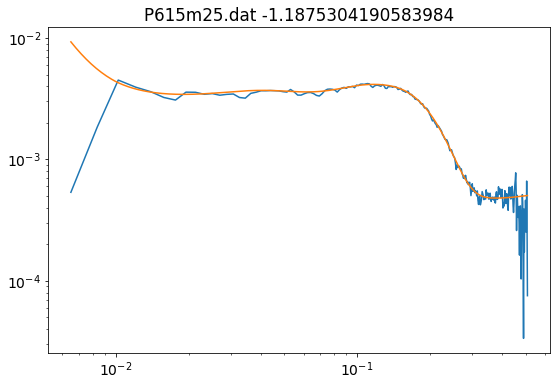

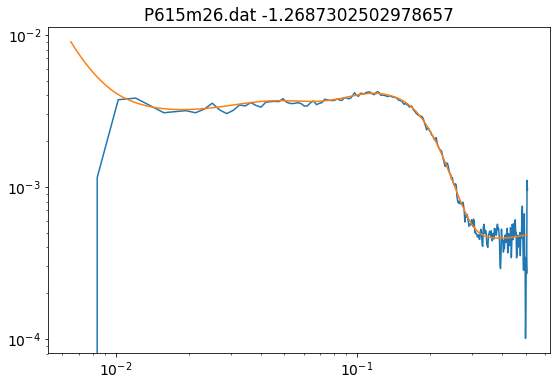

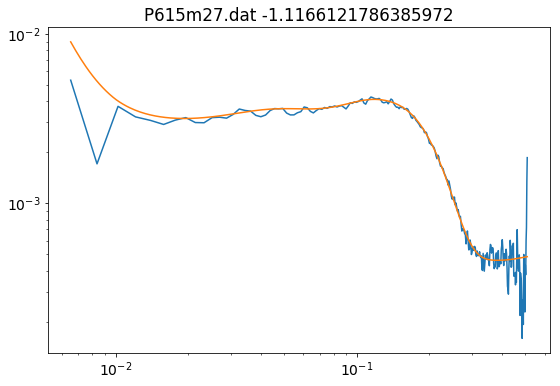

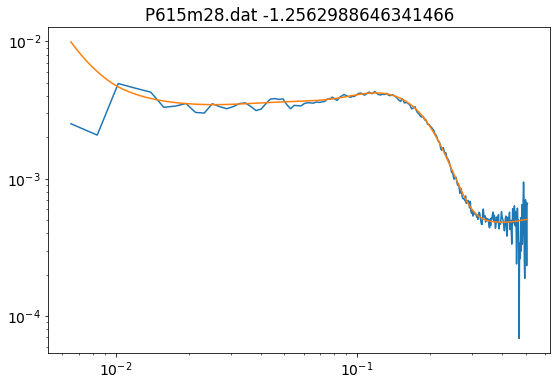

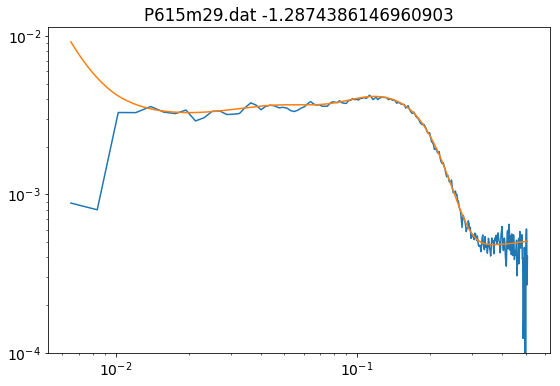

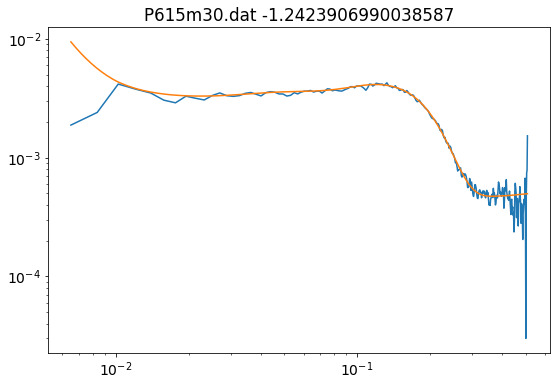

In [12]:
R2s = {}

for ajuste in ajustes[:1]:
    df_ajuste = pd.read_csv(ajuste, sep=';', decimal='.')
    for num, line in enumerate(df_ajuste.iterrows()):
        nome = line[1][0]
        
    
        params = line[1][1::2]
        
        exp_index = 0
        for i, dado in enumerate(corr_aj_dado[ajuste]):
            if nome in dado:
                exp_index = i

        #pos = find_pos(nome).replace('ave', 'Média')
        exp = pd.read_csv(corr_aj_dado[ajuste][exp_index], sep=' ', header=2, names=['q', 'I', 'err'])
        #exp = exp.iloc[:ultimo_ponto, :]
        
        primeiro_q = np.log10( exp.iloc[0, 0] / 10)
        ultimo_q = np.log10( exp.iloc[-1, 0] / 10)
        qs = np.logspace(primeiro_q, ultimo_q, len(exp['I']))
        Is = WLM_whole_q(qs, *params)
        
        SSres = sum((exp['I'] - Is) ** 2)
        SStot = sum((exp['I'] - np.mean(exp['I'])) ** 2 )
        R2 = 1 - SSres / SStot
        R2s[nome] = R2
        
        fig, ax = plt.subplots(1, 1, figsize=(9,6))
        ax.plot(exp['q'] / 10, exp['I'])
        ax.plot(qs, Is)
        ax.set_title(nome + ' ' + str(R2))
        ax.set(xscale='log', yscale='log')
        
        #print(nome, SSres, SStot, R2)
        


Resultado: Melhor não calcular. Valores meio absurdos

# Criar tabelas com os parâmetros bons

In [67]:
df_params = pd.DataFrame()
master_df = pd.read_csv(ajustes[0], sep=';', decimal='.')

param_para_salvar = [
    'scale',
    'd_head',
    'rad_core',
    'rho_rel',
    'd_cq',
    'nu_rpa'
]

dict_errs = {}
for param, err in zip(master_df.columns[1:-1:2], master_df.columns[2:-1:2]):
    dict_errs[param] = err

params_com_errs = ['name']

for param in param_para_salvar:
    params_com_errs.append(param)
    params_com_errs.append(dict_errs[param])
    
for ajuste in ajustes:
    df = pd.read_csv(ajuste, sep=';', decimal='.')
    linhas_a_salvar = df['name'].str.contains('ave') | df['name'].str.contains('01')
    df_params = df_params.append(df[linhas_a_salvar][params_com_errs])

df_params.to_csv('./ajustes_combinados.csv', sep=';', index=False)

# Algarismos significativos

In [68]:
def count_args(string):
    n_alg = 0
    for i, pos in enumerate(string):
        if pos == '0' or pos == '.':
            n_alg += 1
            continue
        else:
            break
    return n_alg

        
newfile = ''
f = open('ajustes_combinados.csv', 'r')

for i, line in enumerate(f):
    if i == 0:
        newfile += line
        continue
    concs = line.split(';')[:1]
    params = line.split(';')[1:]
    newline = concs
    for j, value in enumerate(params):
        if j % 2:  # in err
            value = value.rstrip()
            n_alg = count_args(value)
            if value == '0':
                n_alg = 3
            if n_alg == 0:
                n_alg = 1
            #value = value[:n_alg + 1]
            value = str(np.round(float(value), n_alg-1))
            #params[j - 1] = params[j - 1][:n_alg + 1]
            params[j - 1] = str(np.round(float(params[j-1]), n_alg-1))
            newline = newline + [params[j - 1], value]
    newfile += ';'.join(newline) + '\n'
f.close()

with open('ajustes_combinados_alg.csv', 'w') as fhand:
    fhand.write(newfile)

# Flow-Through

In [19]:
FT_files = glob.glob('./FT/*')
FT_files

FT_files = [
    FT_files[0],
    FT_files[-2],
    FT_files[1],
    FT_files[2],
    FT_files[-1]
]

## Todas as misturas testadas

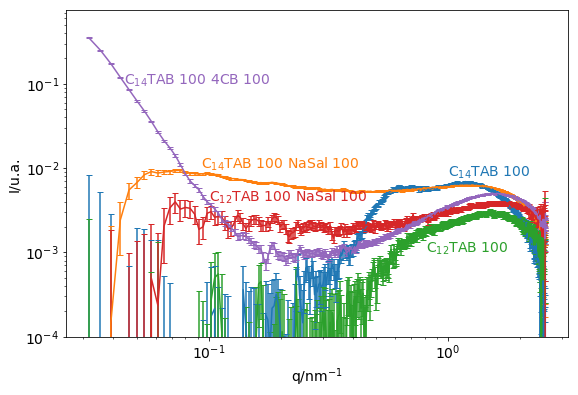

In [20]:
mpl.rcParams.update({'font.size': 14, 'text.usetex':False})
fig, ax = plt.subplots(1, 1, figsize=(9,6))

for file in FT_files:
    df = pd.read_csv(file, sep=' ', names=['q', 'I', 'err', 'lixo'], header=1)
    composicao = file.split('_')[1:]
    composicao = (' '.join(composicao).replace('NaSal', 'NaSal ').replace('TTAB', 'TTAB ').replace('DTAB', 'DTAB ')
    .replace('.dat', '').replace('mM', ' ').replace('4CB', '4CB '))
    ax.errorbar(df['q'], df['I'], yerr=df['err'],
               capsize=3, label=composicao)
    
ax.set(xscale='log', yscale='log', xlabel='q/nm$^{-1}$', ylabel='I/u.a.')
ax.set_ylim(bottom=1E-4)
#ax.legend()

ax.text(s='C$_{14}$TAB 100', x=1E0, y=0.8E-2, color='C0', ha='left')
ax.text(s='C$_{14}$TAB 100 NaSal 100', x=2E-1, y=1E-2, color='C1', ha='center')
ax.text(s='C$_{12}$TAB 100', x=1.2E0, y=1E-3, color='C2', ha='center')
ax.text(s='C$_{12}$TAB 100 NaSal 100', x=1E-1, y=4E-3, color='C3', ha='left')
ax.text(s='C$_{14}$TAB 100 4CB 100', x=9E-2, y=1E-1, color='C4', ha='center')

fig.savefig('../../../saxs/FT_amostras.pdf')

## TTAB com e sem NaSal

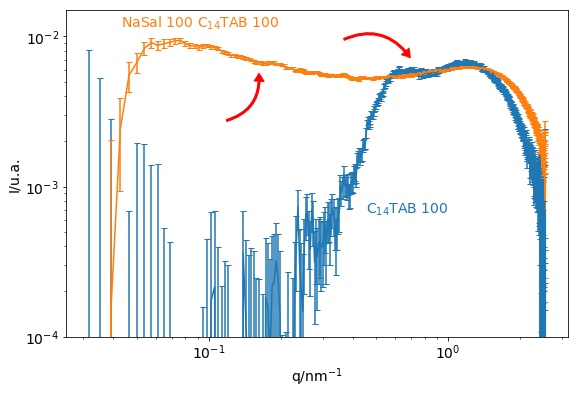

In [22]:
mpl.rcParams.update({'font.size': 14, 'text.usetex':False})

fig, ax = plt.subplots(1, 1, figsize=(9,6))

for file in FT_files[0:2]:
    df = pd.read_csv(file, sep=' ', names=['q', 'I', 'err', 'lixo'], header=1)
    composicao = file.split('_')[1:]
    composicao = (' '.join(composicao).replace('NaSal', 'NaSal ').replace('TTAB', 'TTAB ').replace('DTAB', 'DTAB ')
    .replace('.dat', '').replace('mM', ' ').replace('4CB', '4CB '))
    ax.errorbar(df['q'], df['I'], yerr=df['err'],
               capsize=3, label=composicao)
    
ax.set(xscale='log', yscale='log', xlabel='q/nm$^{-1}$', ylabel='I/u.a.')
ax.set_ylim(bottom=1E-4)

an1 = ax.annotate(s='', xy=(0.1623, 0.005689), xytext=(0.11889, 0.002753), 
        arrowprops={'width':2, 'headwidth':10, 'headlength':8, 'connectionstyle':'arc3, rad=+.4' , 'color':'r'}
                 )

an2 = ax.annotate(s='', xy=(0.6955, 0.007221), xytext=(0.3676, 0.00956), 
        #arrowprops={'arrowstyle':'->', 'connectionstyle':'arc3, rad=-.4' , 'color':'r'}
                  arrowprops={'width':2, 'headwidth':10, 'headlength':8, 'connectionstyle':'arc3, rad=-.4', 'color':'r'}
                 )

ax.text(s='NaSal 100 C$_{14}$TAB 100', x=0.092, y=0.01144, ha='center', color='C1')
ax.text(s='C$_{14}$TAB 100', x=0.4525, y=0.0006591, color='C0')

fig.savefig('../../../saxs/tr_comparacao_antes_depois.pdf')

# Problema com o background

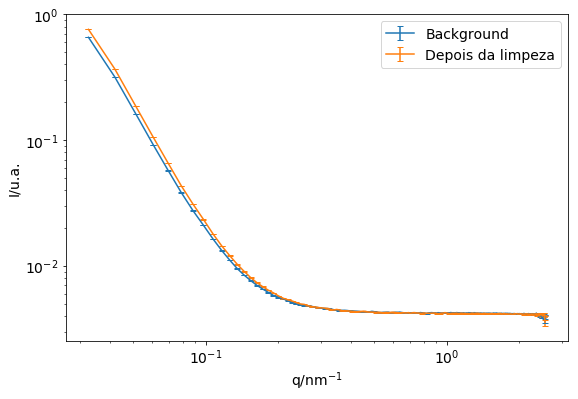

In [77]:
back = glob.glob('*water*')
back

fig, ax = plt.subplots(1, 1, figsize=(9,6))
nomes = ['Background', 'Depois da limpeza']
nomes.reverse()

for file in back[::-1]:
    df = pd.read_csv(file, sep=' ', names=['q', 'I', 'err', 'lixo'], header=1)
    ax.errorbar(df['q'], df['I'], yerr=df['err'],
               capsize=3, label=nomes.pop())
    
ax.set(xscale='log', yscale='log', xlabel='q/nm$^{-1}$', ylabel='I/u.a.')
ax.legend()
#ax.set_ylim(bottom=1E-4)
fig.savefig('../../../saxs/problema_limpeza.pdf')